# Introduction

In the game of chess, there is a chess rating system that estimates the strength of a player based on their performance in previous games. The higher a player's rating, the better the player typically is. Ratings on the site Lichess.org range from about 800 to 3000. An 800 rating is extremely bad and a rating of 3000 is world-class elite level.

On the popular chess YouTube channel GothamChess, there is a series called "Guess The Elo" where he watches a game of chess being played without seeing the ratings of the players. After the game is completed, he attempts to guess the rating of both players. The first episode of his series can be seen here for an example: https://www.youtube.com/watch?v=0baCL9wwJTA

The goal of this module is to do exactly the same as the "Guess The Elo" series, except with data. It will use data from completed chess games to predict a player's rating. For simplicity sake, this module will guess the rating of the player who plays with the white pieces. We can expect the model to guess the rating of the player who plays with the black pieces to be nearly identical.

After a game of online chess is played, a number of stats about the game are saved. Some example stats are numbers of mistakes made by each player, number of blunders (aka very bad mistakes) made by each player, and so on. These are the stats that will be used to try to predict the player's rating.

The data is pulled from https://www.kaggle.com/ahmedalghafri/lichess-chess-games-statistics?select=Chess+games+stats.csv, which was pulled from the chess website Lichess.org. The dataset includes the ratings of each players for the target variable. For potential feature variables, the dataset includes all relevant statistics from individual chess games.

# Loading in the data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [2]:
chess_df = pd.read_csv('Chess games stats.csv', index_col=0)

# no use for the game ID, so will be dropping it
chess_df.drop(['Game ID'], axis=1, inplace=True)

In [3]:
chess_df.head(10)

,White Rating,Black Rating,Opening ECO,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders
0,1441,1559,C20,4,32,2,2,0,87,2,4,1
1,1258,1567,C46,6,43,0,0,1,6,0,0,0
2,1697,1712,C68,7,11,1,0,0,42,1,0,2
3,1978,1868,D31,5,21,3,0,0,53,6,0,1
4,2073,1816,A01,2,35,3,2,0,50,6,3,0
5,1944,2052,C44,9,79,3,0,2,62,3,1,1
6,1500,2058,C50,6,50,4,1,1,91,5,1,3
7,1880,1919,D80,7,9,0,0,0,49,3,1,0
8,2209,2185,B06,7,93,4,3,4,71,4,4,2
9,2296,2323,D32,6,65,2,4,2,32,4,0,1


# Basic EDA

In [4]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18637 entries, 0 to 18636
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   White Rating                    18637 non-null  int64 
 1   Black Rating                    18637 non-null  int64 
 2   Opening ECO                     18637 non-null  object
 3   Opening Ply                     18637 non-null  int64 
 4   White Centi-pawn Loss           18637 non-null  int64 
 5   White's Number of Inaccuracies  18637 non-null  int64 
 6   White's Number of Mistakes      18637 non-null  int64 
 7   White's Number of Blunders      18637 non-null  int64 
 8   Black Centi-pawn Loss           18637 non-null  int64 
 9   Black's Number of Inaccuracies  18637 non-null  int64 
 10  Black's Number of Mistakes      18637 non-null  int64 
 11  Black's Number of Blunders      18637 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 1.8+ MB


In [5]:
chess_df.describe()

,White Rating,Black Rating,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders
count,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000,18637.000000
mean,1774.528519,1776.729678,5.319043,58.814294,3.258947,1.325643,2.115738,60.778451,3.283254,1.332242,2.118206
std,314.840181,317.424527,3.058254,36.622111,2.404746,1.390271,2.078614,38.316602,2.420974,1.383967,2.094702
min,784.000000,780.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1551.000000,1552.000000,3.000000,33.000000,1.000000,0.000000,1.000000,33.000000,1.000000,0.000000,1.000000
50%,1782.000000,1781.000000,5.000000,53.000000,3.000000,1.000000,2.000000,55.000000,3.000000,1.000000,2.000000
75%,1991.000000,1996.000000,7.000000,77.000000,5.000000,2.000000,3.000000,80.000000,5.000000,2.000000,3.000000
max,2997.000000,2995.000000,28.000000,517.000000,19.000000,12.000000,18.000000,550.000000,22.000000,12.000000,22.000000


In [6]:
chess_df.corr()

,White Rating,Black Rating,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders
White Rating,1.000000,0.796545,0.263673,-0.304940,-0.045656,-0.053277,-0.146148,-0.232100,-0.000682,-0.009072,-0.107219
Black Rating,0.796545,1.000000,0.248660,-0.247559,-0.003536,-0.019075,-0.115130,-0.306389,-0.043940,-0.053958,-0.152342
Opening Ply,0.263673,0.248660,1.000000,-0.137593,-0.108823,-0.074969,-0.079829,-0.124761,-0.086753,-0.054686,-0.079431
White Centi-pawn Loss,-0.304940,-0.247559,-0.137593,1.000000,0.205918,0.323447,0.679016,0.560126,0.052996,0.179625,0.481905
White's Number of Inaccuracies,-0.045656,-0.003536,-0.108823,0.205918,1.000000,0.330431,0.309132,0.011623,0.454424,0.298290,0.268984
White's Number of Mistakes,-0.053277,-0.019075,-0.074969,0.323447,0.330431,1.000000,0.346850,0.160787,0.313254,0.386577,0.372138
White's Number of Blunders,-0.146148,-0.115130,-0.079829,0.679016,0.309132,0.346850,1.000000,0.436429,0.262760,0.355047,0.757334
Black Centi-pawn Loss,-0.232100,-0.306389,-0.124761,0.560126,0.011623,0.160787,0.436429,1.000000,0.192718,0.292587,0.653319
Black's Number of Inaccuracies,-0.000682,-0.043940,-0.086753,0.052996,0.454424,0.313254,0.262760,0.192718,1.000000,0.314683,0.312071
Black's Number of Mistakes,-0.009072,-0.053958,-0.054686,0.179625,0.298290,0.386577,0.355047,0.292587,0.314683,1.000000,0.331565


In [7]:
col_list = [col for col in chess_df.columns if chess_df[col].dtype == 'int64']
print(col_list)
print(len(col_list))

['White Rating', 'Black Rating', 'Opening Ply', 'White Centi-pawn Loss', "White's Number of Inaccuracies", "White's Number of Mistakes", "White's Number of Blunders", 'Black Centi-pawn Loss', "Black's Number of Inaccuracies", "Black's Number of Mistakes", "Black's Number of Blunders"]
11


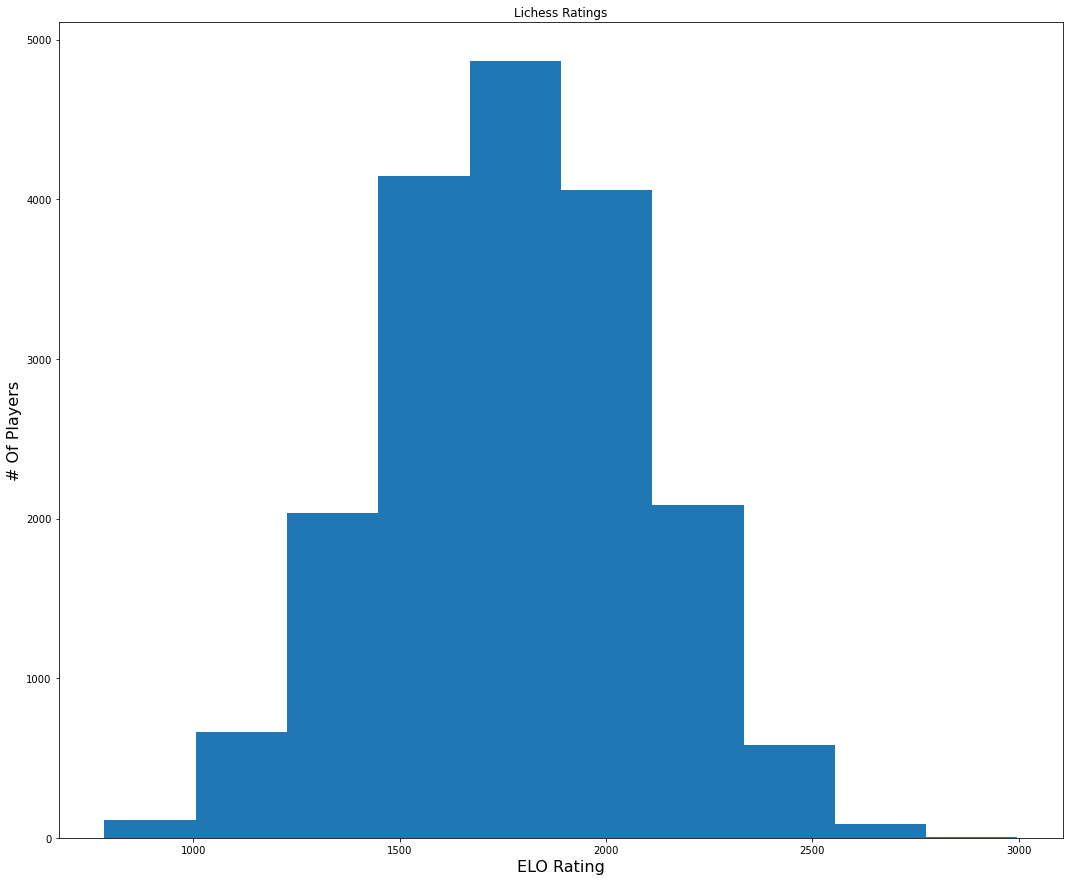

In [13]:
plt.figure(figsize=(18,15))
n = 1

plt.subplot(1, 1, 1)
plt.hist(chess_df['White Rating'])
plt.title('Lichess Ratings')
plt.xlabel('ELO Rating', fontsize=16)
plt.ylabel('# Of Players', fontsize=16)
xtick.labelsize

plt.show()

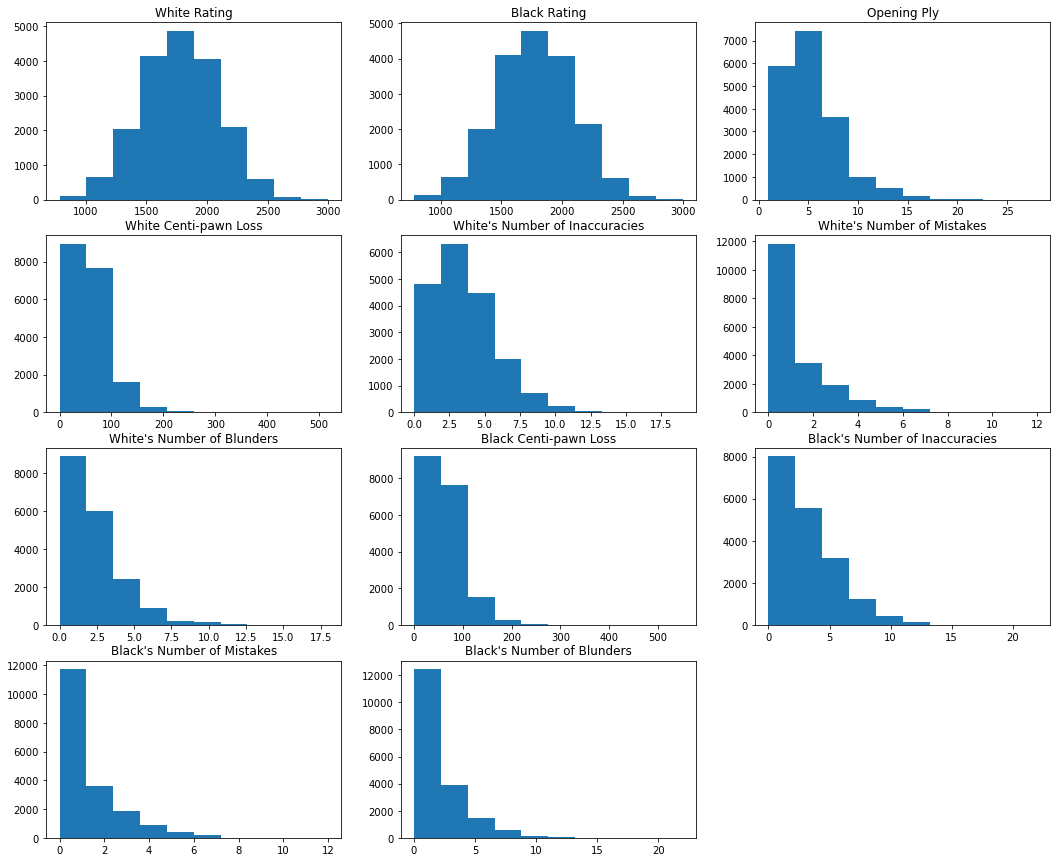

In [58]:
plt.figure(figsize=(18,15))
n = 1

for col in col_list:
    plt.subplot(4, 3, n)
    n += 1
    plt.hist(chess_df[col])
    plt.title(col)

plt.show()

In [59]:
chess_df = pd.concat([chess_df, pd.get_dummies(chess_df['Opening ECO'])], axis=1)
chess_df.drop(['Opening ECO', 'Black Rating'], axis=1, inplace=True)
chess_df

,White Rating,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders,...,E87,E90,E91,E92,E93,E94,E95,E97,E98,E99
0,1441,4,32,2,2,0,87,2,4,1,...,0,0,0,0,0,0,0,0,0,0
1,1258,6,43,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1697,7,11,1,0,0,42,1,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1978,5,21,3,0,0,53,6,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2073,2,35,3,2,0,50,6,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18632,884,2,56,5,1,2,94,4,4,3,...,0,0,0,0,0,0,0,0,0,0
18633,1187,3,38,5,0,1,12,2,0,0,...,0,0,0,0,0,0,0,0,0,0
18634,1450,3,64,9,4,4,36,7,2,2,...,0,0,0,0,0,0,0,0,0,0
18635,1959,7,14,1,0,0,34,6,1,1,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# target variable will be white rating. appears normal in the plots, but just want to verify...

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(chess_df['White Rating'])
norm_stats = normaltest(chess_df['White Rating'])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

# p value far below 0.05 -> normal

Jarque-Bera test statistics is 41.559404833519416 and p value is 9.45126421569853e-10
Normality test statistics is 52.72355570651982 and p value is 3.5581589515965665e-12


In [61]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18637 entries, 0 to 18636
Columns: 427 entries, White Rating to E99
dtypes: int64(10), uint8(417)
memory usage: 9.0 MB


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(chess_df.loc[:, chess_df.columns != 'White Rating'], chess_df['White Rating'], test_size=0.2, random_state=0)

print(f"The number of observations in training set is {X_train.shape[0]}")
print(f"The number of observations in test set is {X_test.shape[0]}")

The number of observations in training set is 14909
The number of observations in test set is 3728


In [63]:
X_train_with_openings = X_train.copy()
X_test_with_openings = X_test.copy()

In [64]:
X_train.head(25)

,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders,A00,...,E87,E90,E91,E92,E93,E94,E95,E97,E98,E99
18564,3,35,3,0,1,77,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
134,4,65,4,3,2,30,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
15288,7,44,5,2,0,19,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10868,8,16,2,0,0,66,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4685,5,72,3,2,3,113,1,3,2,0,...,0,0,0,0,0,0,0,0,0,0
7693,8,43,2,0,3,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3947,15,79,5,2,2,101,4,2,4,0,...,0,0,0,0,0,0,0,0,0,0
8457,1,64,5,3,2,98,10,1,4,1,...,0,0,0,0,0,0,0,0,0,0
11088,6,47,5,0,8,37,5,1,6,0,...,0,0,0,0,0,0,0,0,0,0
10673,4,61,7,0,3,59,7,1,4,0,...,0,0,0,0,0,0,0,0,0,0


# PCA

In [65]:
# have a ton of variables. can cut down on the dimensionality with PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [66]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_train_scaled.head()

,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders,A00,...,E87,E90,E91,E92,E93,E94,E95,E97,E98,E99
0,-0.761988,-0.655070,-0.108004,-0.957527,-0.537819,0.426571,-0.112948,-0.964652,-0.057314,-0.191424,...,-0.014187,-0.042594,-0.028382,-0.028382,-0.00819,-0.016382,-0.011583,-0.023171,-0.011583,-0.00819
1,-0.434672,0.164439,0.310348,1.201869,-0.056988,-0.803155,-0.528020,-0.243280,-0.057314,-0.191424,...,-0.014187,-0.042594,-0.028382,-0.028382,-0.00819,-0.016382,-0.011583,-0.023171,-0.011583,-0.00819
2,0.547275,-0.409218,0.728700,0.482070,-1.018651,-1.090963,-0.943092,-0.243280,-1.015800,-0.191424,...,-0.014187,-0.042594,-0.028382,-0.028382,-0.00819,-0.016382,-0.011583,-0.023171,-0.011583,-0.00819
3,0.874591,-1.174092,-0.526356,-0.957527,-1.018651,0.138763,-1.358164,-0.243280,-0.536557,-0.191424,...,-0.014187,-0.042594,-0.028382,-0.028382,-0.00819,-0.016382,-0.011583,-0.023171,-0.011583,-0.00819
4,-0.107356,0.355657,-0.108004,0.482070,0.423844,1.368489,-0.943092,1.199465,-0.057314,-0.191424,...,-0.014187,-0.042594,-0.028382,-0.028382,-0.00819,-0.016382,-0.011583,-0.023171,-0.011583,-0.00819


In [67]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)

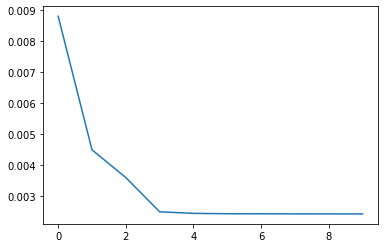

[0.00880543 0.00450034 0.00360735 0.00250429 0.00245397 0.00244158
 0.00243916 0.00243768 0.00243671 0.00243584]


In [68]:
# Print scree plot
plt.plot(pca.explained_variance_ratio_)
plt.show()

print(pca.explained_variance_ratio_)

The explained_variance_ratio values are very small. Trying PCA to see how many features are needed to explain 95% of the variance...

In [69]:
pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train_scaled)

In [70]:
len(pca.explained_variance_ratio_)

387

Still have 387 features after doing PCA. Does not make sense to implement PCA. Going to drop the openings columns entirely for the OLS model.

In [71]:
X_train = X_train.iloc[:, :9]
X_test = X_test.iloc[:, :9]

In [22]:
X_train.head()

,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders
18564,3,35,3,0,1,77,3,0,2
134,4,65,4,3,2,30,2,1,2
15288,7,44,5,2,0,19,1,1,0
10868,8,16,2,0,0,66,0,1,1
4685,5,72,3,2,3,113,1,3,2


# 1) OLS

In [23]:
from sklearn import linear_model

# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

X_train_OLS = X_train.copy()
# Fit method estimates the coefficients using OLS
lrm.fit(X_train_OLS, y_train)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [22.48862451 -2.27615123 -3.95075009  1.73454338  3.43590785 -1.24488525
  2.70640323 10.74420882 15.57128864]

Intercept: 
 1813.162818041753


In [24]:
import statsmodels.api as sm

# You need to manually add a constant
# in statsmodels' sm
X_train_OLS = sm.add_constant(X_train_OLS)

results = sm.OLS(y_train, X_train_OLS).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           White Rating   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     316.6
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:12:04   Log-Likelihood:            -1.0559e+05
No. Observations:               14909   AIC:                         2.112e+05
Df Residuals:                   14899   BIC:                         2.113e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1813.1628      8.051    225.204      0.000    1797.381    1828.944
Opening Ply                       22.4886      0.788     28.547      0.000      20.944      24.033
White Centi-pawn Loss             -2.2762      0.116    -19.624      0.000      -2.504      -2.049
White's Number of Inaccuracies    -3.9508      1.226     -3.223      0.001      -6.353      -1.548
White's Number of Mistakes         1.7345      2.101      0.826      0.409      -2.384       5.853
White's Number of Blunders         3.4359      2.427      1.416      0.157      -1.321       8.193
Black Centi-pawn Loss             -1.2449      0.111    -11.258      0.000      -1.462      -1.028
Black's Number of Inaccuracies     2.7064      1.202      2.251      0.024       0.350       5.063
Black's Number of Mistakes        10.7442      2.073      5.184      0.000       6.682      14.807
Black's Number of Blunders        15.5713      2.414      6.451      0.000      10.840      20.302
==============================================================================
Omnibus:                       15.590   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.770
Skew:                          -0.022   Prob(JB):                      0.00102
Kurtosis:                       2.858   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Can drop the features that are not statistically significant.

In [25]:
X_train_OLS.drop(["White's Number of Mistakes"], axis=1, inplace=True)
X_train_OLS = sm.add_constant(X_train_OLS)

In [26]:
results = sm.OLS(y_train, X_train_OLS).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           White Rating   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     356.1
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:12:04   Log-Likelihood:            -1.0559e+05
No. Observations:               14909   AIC:                         2.112e+05
Df Residuals:                   14900   BIC:                         2.113e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1813.4765      8.042    225.496      0.000    1797.713    1829.240
Opening Ply                       22.4749      0.788     28.536      0.000      20.931      24.019
White Centi-pawn Loss             -2.2450      0.110    -20.471      0.000      -2.460      -2.030
White's Number of Inaccuracies    -3.9228      1.225     -3.202      0.001      -6.324      -1.521
White's Number of Blunders         3.0336      2.377      1.276      0.202      -1.626       7.693
Black Centi-pawn Loss             -1.2713      0.106    -12.013      0.000      -1.479      -1.064
Black's Number of Inaccuracies     2.8968      1.180      2.455      0.014       0.584       5.209
Black's Number of Mistakes        11.2992      1.960      5.763      0.000       7.456      15.142
Black's Number of Blunders        16.1514      2.309      6.995      0.000      11.626      20.677
==============================================================================
Omnibus:                       15.648   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.823
Skew:                          -0.022   Prob(JB):                     0.000996
Kurtosis:                       2.858   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
X_train_OLS.drop(["White's Number of Blunders"], axis=1, inplace=True)
X_train_OLS = sm.add_constant(X_train_OLS)

In [28]:
results = sm.OLS(y_train, X_train_OLS).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           White Rating   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     406.7
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:12:04   Log-Likelihood:            -1.0559e+05
No. Observations:               14909   AIC:                         2.112e+05
Df Residuals:                   14901   BIC:                         2.113e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1812.6153      8.014    226.182      0.000    1796.907    1828.324
Opening Ply                       22.4952      0.787     28.567      0.000      20.952      24.039
White Centi-pawn Loss             -2.1532      0.083    -26.016      0.000      -2.315      -1.991
White's Number of Inaccuracies    -4.0630      1.220     -3.330      0.001      -6.455      -1.671
Black Centi-pawn Loss             -1.3318      0.095    -14.073      0.000      -1.517      -1.146
Black's Number of Inaccuracies     3.1002      1.169      2.652      0.008       0.809       5.392
Black's Number of Mistakes        11.8997      1.903      6.252      0.000       8.169      15.630
Black's Number of Blunders        18.2373      1.631     11.183      0.000      15.041      21.434
==============================================================================
Omnibus:                       15.851   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.994
Skew:                          -0.022   Prob(JB):                     0.000915
Kurtosis:                       2.857   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2) Random Forest

In [29]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [30]:
# can include the openings in this model
X_train_rf = X_train_with_openings.copy().astype(np.int64)
X_train_rf.head()

,Opening Ply,White Centi-pawn Loss,White's Number of Inaccuracies,White's Number of Mistakes,White's Number of Blunders,Black Centi-pawn Loss,Black's Number of Inaccuracies,Black's Number of Mistakes,Black's Number of Blunders,A00,...,E87,E90,E91,E92,E93,E94,E95,E97,E98,E99
18564,3,35,3,0,1,77,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
134,4,65,4,3,2,30,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
15288,7,44,5,2,0,19,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10868,8,16,2,0,0,66,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4685,5,72,3,2,3,113,1,3,2,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14909 entries, 18564 to 2732
Columns: 426 entries, Opening Ply to E99
dtypes: int64(426)
memory usage: 48.6 MB


In [32]:
# running the base rfr model
rfr = ensemble.RandomForestRegressor()

cross_val_score(rfr, X_train_rf, y_train, cv=5)

array([0.19456915, 0.17125772, 0.1728706 , 0.15468644, 0.16526116])

In [33]:
# tuning the rfr model. parameter optimization tuning code grabbed from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False] 

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = ensemble.RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 5 different combinations (5 for time-sake), and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train_rf, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [35]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [36]:
params = rf_random.best_params_

rfr = ensemble.RandomForestRegressor(**params)

cross_val_score(rfr, X_train_rf, y_train, cv=5)

array([0.20857711, 0.19261937, 0.19539343, 0.18150038, 0.18423946])

In [37]:
rfr.fit(X_train_rf, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=1400)

In [38]:
# rfr appears to be a slight improvement over OLS

# 3) Support Vector Regression

In [39]:
from sklearn.svm import SVR

# can include the openings in this model
X_train_svr = X_train_with_openings.copy().astype(np.int64)

svr = SVR()
svr.fit(X_train_svr, y_train)

SVR()

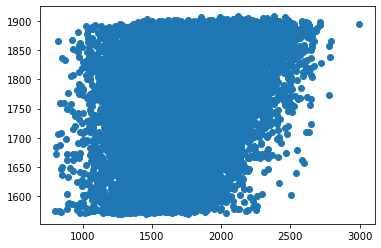

In [40]:
plt.scatter(y_train, svr.predict(X_train_svr))

In [41]:
svr.score(X_train_svr, y_train)

0.1089992578599901

In [42]:
# base model does not perform very well. can try to tune the parameters
# selecting very few parameters for time-sake. SVR does not appear to work very well here anyway
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVR(), param_grid, refit = True, cv = 2, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train_svr, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.001 total time= 1.3min
[CV 2/2] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.001 total time= 1.2min
[CV 1/2] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.000 total time= 1.2min
[CV 2/2] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.001 total time= 1.2min
[CV 1/2] END .........C=1, gamma=1, kernel=rbf;, score=-0.001 total time= 1.4min
[CV 2/2] END .........C=1, gamma=1, kernel=rbf;, score=-0.001 total time= 1.4min
[CV 1/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.000 total time= 1.3min
[CV 2/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.000 total time= 1.2min
[CV 1/2] END ........C=10, gamma=1, kernel=rbf;, score=-0.000 total time= 1.3min
[CV 2/2] END ........C=10, gamma=1, kernel=rbf;, score=-0.001 total time= 1.4min
[CV 1/2] END .......C=10, gamma=0.1, kernel=rbf;, score=0.009 total time= 1.3min
[CV 2/2] END .......C=10, gamma=0.1, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1],
                         'kernel': ['rbf']},
             verbose=3)

In [43]:
print(grid.best_params_)
svr_params = grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [44]:
svr = SVR(**svr_params)
svr.fit(X_train_svr, y_train)

SVR(C=10, gamma=0.1)

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X_train_svr, y_train, cv=5)
# Quite bad!

array([0.01533603, 0.0126824 , 0.01370314, 0.01620107, 0.01454327])

# 4) Gradient Boosting

In [46]:
params = {'n_estimators': 500,
          'max_depth': 2
         }

X_train_gbr = X_train_with_openings.copy().astype(np.int64)

# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train_gbr, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=500)

In [47]:
gbr.score(X_train_gbr, y_train)

0.26174729954949805

In [48]:
# hand-tuning for now for the sake of time.

gbr_params = {'n_estimators': 400,
          'max_depth': 3,
          'learning_rate': 0.1,
          'subsample': 0.8,
          'min_samples_split': 3,
         }

# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor(**gbr_params)
gbr.fit(X_train_gbr, y_train)

gbr.score(X_train_gbr, y_train)

0.30925710002096485

# Model Comparison

There were 4 models used in this module and they all have now been trained. Now it is time to compare the predictive power of each model by looking at the test data.

**1) OLS**

In [73]:
X_test_OLS = X_test.copy()

In [77]:
# the OLS model had white mistakes and blunders dropped for the model. will do the same to the test data
X_test_OLS.drop(["White's Number of Mistakes"], axis=1, inplace=True)
X_test_OLS.drop(["White's Number of Blunders"], axis=1, inplace=True)

In [90]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test_OLS = sm.add_constant(X_test_OLS)

# making predictions here
y_preds_OLS = results.predict(X_test_OLS)

In [93]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_preds_OLS))
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_OLS)}")

0.15360440245445617
Mean squared error of the prediction is: 84551.1210017664


**2) Random Forest**

In [94]:
y_preds_rfr = rfr.predict(X_test_with_openings)

In [95]:
rfr.score(X_test_with_openings, y_test)

0.1864470745648028

In [96]:
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_rfr)}")

Mean squared error of the prediction is: 81270.28547795705


**3) Support Vector Regression**

In [97]:
y_preds_svr = svr.predict(X_test_with_openings)

In [98]:
svr.score(X_test_with_openings, y_test)

0.014361482901883105

In [99]:
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_svr)}")

Mean squared error of the prediction is: 98460.86364914037


**4) Gradient Boosting**

In [100]:
y_preds_gbr = gbr.predict(X_test_with_openings)

In [101]:
gbr.score(X_test_with_openings, y_test)

0.21286865906577523

In [102]:
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds_gbr)}")

Mean squared error of the prediction is: 78630.88778416185


# Model Selection Conclusion

In terms of predictive ability, gradient boosting is the best choice for a model. It has both the highest R^2 value and the lowest mean squared error. With that said, it is not a very strong model. 

While it may be fun to predict the rating of a chess player after viewing one game, it is certainly not accurate. Thinking back on this, the fact that it is difficult to predict a player's rating after viewing one of his or her games definitely adds to the fun of the "Guess The Elo" YouTube series. It can provide a lot of "I never would have guessed that" moments. It can also provide moments where you are amazed at how well a low-level rating player can play and provide moments where you are amazed at how poorly a high-level rating player can play. If it was easy to predict, it would be doubtful the YouTube series has as much success as it has now.